## **<font style="color:rgb(134,19,348)">Implementing the ConvLSTM Approach</font>**

In this step, we will implement the first approach by using a combination of ConvLSTM cells. A ConvLSTM cell is a variant of an LSTM network that contains convolutions operations in the network. it is an LSTM with convolution embedded in the architecture, which makes it capable of identifying spatial features of the data while keeping into account the temporal relation. 

<center>
<img src="https://drive.google.com/uc?export=view&id=1KHN_JFWJoJi1xQj_bRdxy2QgevGOH1qP" width= 500px>
</center>


For video classification, this approach effectively captures the spatial relation in the individual frames and the temporal relation across the different frames. As a result of this convolution structure, the ConvLSTM is capable of taking in 3-dimensional input `(width, height, num_of_channels)` whereas a simple LSTM only takes in 1-dimensional input hence an LSTM is incompatible for modeling Spatio-temporal data on its own.

You can read the paper [**Convolutional LSTM Network: A Machine Learning Approach for Precipitation Nowcasting**](https://arxiv.org/abs/1506.04214v1) by **Xingjian Shi** (NIPS 2015), to learn more about this architecture.


In [1]:
import cv2
import os
import numpy as np
import keras
from tensorflow.keras.utils import Sequence
import matplotlib.pyplot as plt
import tensorflow as tf
from random import shuffle
from tensorflow.keras.applications import VGG19
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation,Flatten
from keras.layers import LeakyReLU
import keras_tuner
import sys
import h5py
import glob

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    #Restrict Tensorflow to only allocate 6gb of memory on the first GPU
   try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0],
       [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=8192)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
   except RuntimeError as e:
       #virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
from keras_video import VideoFrameGenerator

In [4]:
IMAGE_HEIGHT, IMAGE_WIDTH = 144,144

In [5]:
classes = [i.split(os.path.sep)[4] for i in glob.glob('D:\\Thesis Works\\Datasets\\compiled_short\\*')]
print(classes)
classes.sort()
# some global params
SIZE = (IMAGE_HEIGHT,IMAGE_WIDTH)
CHANNELS = 3
NBFRAME = 20
BS = 8
# pattern to get videos and classes
glob_pattern='D:\\Thesis Works\\Datasets\\compiled_short\\{classname}\\*'
# for data augmentation
data_aug = keras.preprocessing.image.ImageDataGenerator(
    zoom_range=.1,
    horizontal_flip=True,
    rotation_range=8,
    width_shift_range=.2,
    height_shift_range=.2)
# Create video frame generator
train = VideoFrameGenerator(
    classes=classes, 
    glob_pattern=glob_pattern,
    nb_frames=NBFRAME,
    split_val=0.20,
    split_test=0.1,
    shuffle=True,
    batch_size=BS,
    target_shape=SIZE,
    nb_channel=CHANNELS,
    transformation=None,
    use_frame_cache=True)

['NonViolence', 'Violence']
class NonViolence, validation count: 251, test count: 100, train count: 907
class Violence, validation count: 249, test count: 99, train count: 900
Total data: 2 classes for 1807 files for train


In [6]:
valid = train.get_validation_generator()

Total data: 2 classes for 500 files for validation


In [7]:
test = train.get_test_generator()

Total data: 2 classes for 199 files for test


In [14]:
from keras.layers import Conv2D, BatchNormalization, \
    MaxPooling2D, GlobalMaxPool2D,GlobalAveragePooling2D, AveragePooling2D, Conv3D, LSTM, Bidirectional, \
    DepthwiseConv2D,SeparableConv2D, GRU, Attention


from keras.layers import TimeDistributed, GRU, Dense, Dropout
def main_model():
    momentum = 0.9
    model = keras.Sequential()


    
    model.add(Conv2D(32, (3,3),input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, 3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(padding="same"))
    
    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(padding="same"))
              
    model.add(Conv2D(128, (5,5), padding='same', activation="relu"))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(padding='same'))
              
    model.add(Conv2D(512, (3,3), padding='same', activation="relu"))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(padding='same'))

    
    model.add(Conv2D(1024, (5,5), padding='same', activation="relu"))
    model.add(BatchNormalization(momentum=momentum))
    model.add(MaxPooling2D(padding='same'))
              
  
    
    
    
    
    model.add(GlobalMaxPool2D())
    
    model1 = keras.Sequential()
    
    model1.add(TimeDistributed(model, input_shape=(20,IMAGE_WIDTH, IMAGE_HEIGHT,3)))

    model1.add(Bidirectional(LSTM(512,return_sequences=True)))
    model1.add(Bidirectional(LSTM(128,return_sequences=True)))
    model1.add(Bidirectional(LSTM(64)))
    
    
    model1.add(Dense(256,activation="relu"))
    
    
    
    
    model1.add(Dense(2, activation='softmax'))
    return model1

In [15]:


model = main_model()
optimizer = tf.optimizers.Adam(0.0001)
model.compile(
    optimizer,
    'categorical_crossentropy',
    metrics=['accuracy']
)


In [16]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 20, 1024)         13929920  
 ibuted)                                                         
                                                                 
 bidirectional (Bidirectiona  (None, 20, 1024)         6295552   
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 20, 256)          1180672   
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 128)              164352    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 256)              

In [11]:
EPOCHS=60

callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor ='val_loss',factor = 0.1,min_delta=0.02,patience = 5,verbose=1,min_lr=0.0000000001),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0.02,
        patience=20,
        verbose=1,
        mode="auto",
        baseline=None,
        restore_best_weights=False,
    )
    
]
history = model.fit(
    train,
    validation_data=valid,
    verbose=1,
    epochs=EPOCHS,
    callbacks=callbacks
)


Epoch 1/60
225/225 [==============================] - 381s 2s/step - loss: 0.5249 - accuracy: 0.7283 - val_loss: 0.4597 - val_accuracy: 0.7681 - lr: 1.0000e-04
Epoch 2/60
225/225 [==============================] - 57s 253ms/step - loss: 0.4046 - accuracy: 0.8122 - val_loss: 0.4167 - val_accuracy: 0.8226 - lr: 1.0000e-04
Epoch 3/60
225/225 [==============================] - 56s 248ms/step - loss: 0.3269 - accuracy: 0.8578 - val_loss: 0.3394 - val_accuracy: 0.8407 - lr: 1.0000e-04
Epoch 4/60
225/225 [==============================] - 56s 248ms/step - loss: 0.2519 - accuracy: 0.8967 - val_loss: 0.2384 - val_accuracy: 0.9012 - lr: 1.0000e-04
Epoch 5/60
225/225 [==============================] - 56s 248ms/step - loss: 0.2236 - accuracy: 0.9133 - val_loss: 0.2361 - val_accuracy: 0.9032 - lr: 1.0000e-04
Epoch 6/60
225/225 [==============================] - 56s 248ms/step - loss: 0.1763 - accuracy: 0.9378 - val_loss: 0.2279 - val_accuracy: 0.9073 - lr: 1.0000e-04
Epoch 7/60
225/225 [==========

In [ ]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [8]:
loaded_model = tf.keras.models.load_model('lstm-95.h5')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


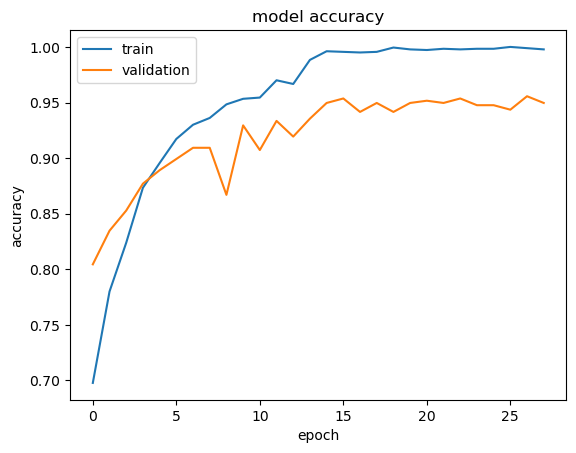

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


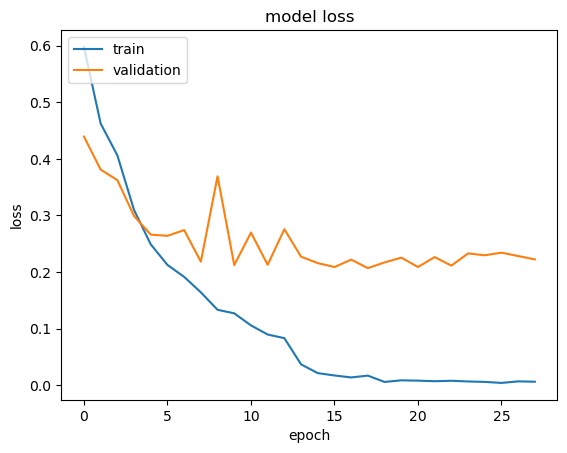

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path.eps', format='eps', dpi=1000)
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('destination_path1.eps', format='eps', dpi=1000)
plt.show()

In [13]:
# load_model.load_weights('checkpoint/')

result = model.evaluate(test)

24/24 [==============================] - 38s 2s/step - loss: 0.0825 - accuracy: 0.9740


In [12]:
model.save('lstm-97.50.h5')

In [11]:
from collections import deque

In [12]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''

    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
#         normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(resized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:

            # Pass the normalized frames to the model and get the predicted probabilities.
            predicted_labels_probabilities = model.predict(np.expand_dims(frames_queue, axis = 0))
            print(predicted_labels_probabilities)
            predicted_labels_probabilities = predicted_labels_probabilities[0]
            print(predicted_labels_probabilities)
            # Get the index of class with highest probability.
            predicted_label = np.argmax(predicted_labels_probabilities)

            # Get the class name using the retrieved index.
            predicted_class_name = classes[predicted_label]
            print(predicted_class_name)
            frames_queue = deque(maxlen = SEQUENCE_LENGTH)

        # Write predicted class name on top of the frame.
#         cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#         # Write The frame into the disk using the VideoWriter Object.
#         video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [31]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
    count = 0
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(resized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            count += 1

            # Pass the normalized frames to the model and get the predicted probabilities.
#             predictions = loaded_model.predict(np.expand_dims(frames_queue, axis = 1))
            
#             print(predictions)
            if count > 17 and count <26:
                predicted_class_name = "True"
            elif count > 38:
                predicted_class_name = "True"
            else:
                predicted_class_name = "False"
#             preds = (predictions > 0.5).astype(int)
#             preds = np.argmax(preds,axis=1)
#             print(predicted_class_name)
            
            color = (0,255,0)
            
            
#             print(preds)
            
#             predicted_label = preds[0]
#             # Get the index of class with highest probability.
# #             predicted_label = np.argmax(predicted_labels_probabilities)

#             # Get the class name using the retrieved index.
#             predicted_class_name = classes[predicted_label]
        
            frames_queue = deque(maxlen = SEQUENCE_LENGTH)
        
        if predicted_class_name == "True":
            color = (0, 255, 0) 
        else:
            color = (0, 0, 255)
                
        text = "Violence: "+predicted_class_name
#       Write predicted class name on top of the frame.
        cv2.putText(frame, text, (35, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

        # Write The frame into the disk using the VideoWriter Object.
        video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [14]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    '''
    This function will perform action recognition on a video using the LRCN model.
    Args:
    video_file_path:  The path of the video stored in the disk on which the action recognition is to be performed.
    output_file_path: The path where the ouput video with the predicted action being performed overlayed will be stored.
    SEQUENCE_LENGTH:  The fixed number of frames of a video that can be passed to the model as one sequence.
    '''

    # Initialize the VideoCapture object to read from the video file.
    video_reader = cv2.VideoCapture(video_file_path)

    # Get the width and height of the video.
    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Initialize the VideoWriter Object to store the output video in the disk.
    video_writer = cv2.VideoWriter(output_file_path, cv2.VideoWriter_fourcc('M', 'P', '4', 'V'), 
                                   video_reader.get(cv2.CAP_PROP_FPS), (original_video_width, original_video_height))

    # Declare a queue to store video frames.
    frames_queue = deque(maxlen = SEQUENCE_LENGTH)

    # Initialize a variable to store the predicted action being performed in the video.
    predicted_class_name = ''
    count = 0
    # Iterate until the video is accessed successfully.
    while video_reader.isOpened():

        # Read the frame.
        ok, frame = video_reader.read() 
        
        # Check if frame is not read properly then break the loop.
        if not ok:
            break

        # Resize the Frame to fixed Dimensions.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        
        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1.
        normalized_frame = resized_frame / 255

        # Appending the pre-processed frame into the frames list.
        frames_queue.append(resized_frame)

        # Check if the number of frames in the queue are equal to the fixed sequence length.
        if len(frames_queue) == SEQUENCE_LENGTH:
            count += 1

            # Pass the normalized frames to the model and get the predicted probabilities.
            predictions = model.predict(np.expand_dims(frames_queue, axis = 0))
            
            print(predictions,count)

            preds = (predictions > 0.5).astype(int)
            preds = np.argmax(preds,axis=0)
            
#             print(preds)
            
            predicted_label = preds[0]


#             # Get the class name using the retrieved index.
            predicted_class_name = classes[predicted_label]
            print(predicted_class_name)
        
            frames_queue = deque(maxlen = SEQUENCE_LENGTH)

# #       Write predicted class name on top of the frame.
#         cv2.putText(frame, predicted_class_name, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)

#         # Write The frame into the disk using the VideoWriter Object.
#         video_writer.write(frame)
        
    # Release the VideoCapture and VideoWriter objects.
    video_reader.release()
    video_writer.release()

In [32]:


# Construct tihe nput youtube video path
input_video_file_path = f'D:\\Thesis Works\\Datasets\\test_videos\\v1_crop.mp4'

output_video_file_path = f'D:\\Thesis Works\\Datasets\\test_videos\\output\\v2_crop.mp4'

# Perform Action Recognition on the Test Video.
predict_on_video(input_video_file_path, output_video_file_path, 20)

# # Display the output video.
# VideoFileClip(output_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()